In [66]:
import galsim
import numpy as np
import numpy.lib.recfunctions as rfn
import fpfs
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

### Shape noise: $\sigma_y$

- Standard deviation of the intrinsic ellipticity distritubtion
- If $\sigma_e$ is the RMS of galaxy intrinsic ellipticities then the shape noise for a single galaxy is $\sigma_e$
- For N galaxies, shape noise reduces by a factor $\sqrt{N}$
- Usually taken to be constant for entire galaxy sample (Chang+,2013)

$\sigma^2_\gamma = \sigma^2_{e} + \sigma^2_m$
where $m$ denotes measurement noise (e.g. image noise)

Assuming no measurement noise, 

$\sigma_\gamma^2 = \frac{\sigma_e^2}{\sqrt{2N}}$
the 2 accounts for the fact shear has two components (ChatGPT, double check this)

In [145]:
sigma_e = 0.26
sigma_y = 1e-3

def get_Ngals(sigma_e, sigma_y):
    return (sigma_e / sigma_y)**2

def get_sigmaY(sigma_e, N):
    return sigma_e / np.sqrt(2*N)

N = get_Ngals(sigma_e, sigma_y)
print(N)

67600.0


In [140]:
def get_sigmaY(sigma_e, N):
    return sigma_e / np.sqrt(2*N)

sigma_y = get_sigmaY(sigma_e, 8e4)
print(sigma_y)

0.00065


In [115]:
# estimate sigma_e for cosmos
cosmos = galsim.COSMOSCatalog()
ntot = len(cosmos)
inds = np.arange(ntot)
gals = cosmos.makeGalaxy(index=inds, noise_pad_size=0, gal_type='parametric')

In [116]:
nn = 128
scale = 0.2
psf = galsim.Moffat(beta=3.5, fwhm=0.8, flux=1.0)
rcut = nn // 4
psf_arr = psf.shift(0.5*scale, 0.5*scale).drawImage(nx=rcut*2, ny=rcut*2, scale=scale).array

gamma1 = 0.02

gals_conv = [] 
for gal in tqdm(gals):
    gal = gal.shear(g1=gamma1)
    gals_conv.append(galsim.Convolve([gal,psf]))

fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=0.52, pix_scale=scale)

p1 = nn //2 - rcut
p2 = nn //2 - rcut
psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

all_mms = []
for gal in tqdm(gals_conv):
    gal_arr = gal.shift(0.5*scale, 0.5*scale).drawImage(nx=nn, ny=nn, scale=scale).array
    coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)
    
    # measure shear with FPFS on individual galaxies
    mms = fpTask.measure(gal_arr, coords)
    mms = fpTask.get_results(mms)
    all_mms.append(mms)
combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

# convert momemnts to ellipticity estimates
ells = fpfs.catalog.fpfs_m2e(combined_mms, const=20)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp
shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(len(gals_conv))
m_bias = abs(shear - gamma1)/gamma1

print(f"shear: {shear:.4f} +/- {shear_err:.4f}", f"m_bias: {m_bias:.4f}")

  0%|          | 36/81499 [00:18<11:41:11,  1.94it/s]


KeyboardInterrupt: 

sigma_e1: 0.0165 sigma_e2: 0.0265


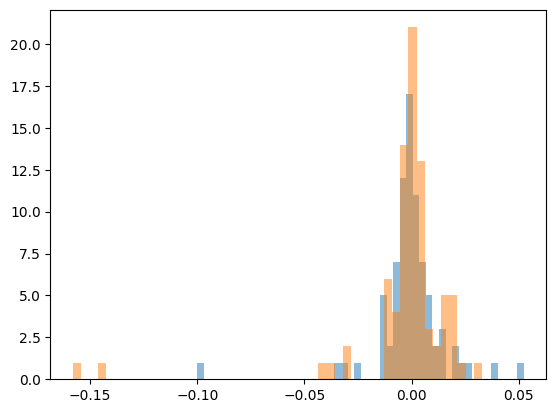

In [108]:
fpfs_e1 = ells['fpfs_e1']
fpfs_e2 = ells['fpfs_e2']

plt.figure()
plt.hist(fpfs_e1, bins=50, alpha=0.5, label='fpfs_e1');
plt.hist(fpfs_e2, bins=50, alpha=0.5, label='fpfs_e2');
sig_e1 = np.std(fpfs_e1)
sig_e2 = np.std(fpfs_e2)
print(f"sigma_e1: {sig_e1:.4f}", f"sigma_e2: {sig_e2:.4f}")